In [1]:
import pandas as pd
import seaborn as sns # data visualization library  
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt 
import math
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 50)

seed = 7
np.random.seed(seed)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TIME_STEPS = 4

def process(filename) :
    features = pd.read_csv(filename, index_col=[0])
    features.fillna(method='ffill', inplace=True)
    
    features['week_start_date'] = pd.to_datetime(features['week_start_date']).astype(np.int64) // 10**9
    cols = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'precipitation_amt_mm', 'week_start_date']
    
    cols = list(features.columns)
    
#     features = features[cols]
    features = features.astype('float32')
    
    for i in range(1, TIME_STEPS): 
        for col in cols:
            features[col + '_prev_' + str(i)] = features[col].shift(-i)
    features.fillna(method='ffill', inplace=True)
    
    return features

In [3]:
SJ_DIVIDE_FACTOR = 20
IQ_DIVIDE_FACTOR = 100

train_feature_filename = "dengue_features_train.csv"
train_label_filename = "dengue_labels_train.csv"

test_feature_filename = "dengue_features_test.csv"

train_features = process(train_feature_filename)
test_features = process(test_feature_filename)

train_labels = pd.read_csv(train_label_filename, index_col=[0])
train_labels = train_labels.drop(['year', 'weekofyear'], axis=1)
train_labels = train_labels.astype('float32')

# train_labels['total_cases'] = train_labels['total_cases'].apply(lambda c : c / DIVIDE_FACTOR)

# for obs in range(1, 2):
#     train_features["T_" + str(obs)] = train_labels.total_cases.shift(obs)

# train_features.fillna(0.00, inplace=True)


test_features.tail()
# train_labels.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,year_prev_1,weekofyear_prev_1,...,station_min_temp_c_prev_2,station_precip_mm_prev_2,year_prev_3,weekofyear_prev_3,week_start_date_prev_3,ndvi_ne_prev_3,ndvi_nw_prev_3,ndvi_se_prev_3,ndvi_sw_prev_3,precipitation_amt_mm_prev_3,reanalysis_air_temp_k_prev_3,reanalysis_avg_temp_k_prev_3,reanalysis_dew_point_temp_k_prev_3,reanalysis_max_air_temp_k_prev_3,reanalysis_min_air_temp_k_prev_3,reanalysis_precip_amt_kg_per_m2_prev_3,reanalysis_relative_humidity_percent_prev_3,reanalysis_sat_precip_amt_mm_prev_3,reanalysis_specific_humidity_g_per_kg_prev_3,reanalysis_tdtr_k_prev_3,station_avg_temp_c_prev_3,station_diur_temp_rng_c_prev_3,station_max_temp_c_prev_3,station_min_temp_c_prev_3,station_precip_mm_prev_3
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
iq,2013.0,22.0,1.369699e+09,0.301471,0.380029,0.280629,0.383186,41.119999,297.774292,298.964294,295.638580,305.500000,292.700012,67.599998,89.989998,41.119999,17.185715,10.100000,27.400000,9.050,32.599998,21.799999,33.000000,2013.0,23.0,...,21.600000,93.199997,2013.0,25.0,1.371514e+09,0.310429,0.302700,0.406614,0.403943,39.540001,295.778564,297.399994,293.648560,305.899994,292.500000,4.700000,89.057144,39.540001,15.137143,8.228572,26.700001,8.480,32.200001,21.799999,34.099998
iq,2013.0,23.0,1.370304e+09,0.247600,0.296343,0.285371,0.350357,71.519997,297.167145,298.328583,295.845703,306.299988,291.600006,45.700001,93.891426,71.519997,17.448572,9.657143,27.520000,10.720,33.799999,21.400000,68.000000,2013.0,24.0,...,21.799999,34.099998,2013.0,26.0,1.372118e+09,0.339467,0.240071,0.356943,0.273600,51.799999,297.372864,299.000000,294.615723,307.299988,289.600006,27.799999,87.029999,51.799999,16.148571,11.542857,27.350000,9.675,32.599998,22.000000,14.900000
iq,2013.0,24.0,1.370909e+09,0.238729,0.251029,0.252586,0.249771,78.959999,295.831421,296.607147,294.894287,304.600006,290.700012,45.220001,94.967140,78.959999,16.410000,7.385714,27.200001,10.075,32.599998,21.600000,93.199997,2013.0,25.0,...,22.000000,14.900000,2013.0,26.0,1.372118e+09,0.339467,0.240071,0.356943,0.273600,51.799999,297.372864,299.000000,294.615723,307.299988,289.600006,27.799999,87.029999,51.799999,16.148571,11.542857,27.350000,9.675,32.599998,22.000000,14.900000
iq,2013.0,25.0,1.371514e+09,0.310429,0.302700,0.406614,0.403943,39.540001,295.778564,297.399994,293.648560,305.899994,292.500000,4.700000,89.057144,39.540001,15.137143,8.228572,26.700001,8.480,32.200001,21.799999,34.099998,2013.0,26.0,...,22.000000,14.900000,2013.0,26.0,1.372118e+09,0.339467,0.240071,0.356943,0.273600,51.799999,297.372864,299.000000,294.615723,307.299988,289.600006,27.799999,87.029999,51.799999,16.148571,11.542857,27.350000,9.675,32.599998,22.000000,14.900000
iq,2013.0,26.0,1.372118e+09,0.339467,0.240071,0.356943,0.273600,51.799999,297.372864,299.000000,294.615723,307.299988,289.600006,27.799999,87.029999,51.799999,16.148571,11.542857,27.350000,9.675,32.599998,22.000000,14.900000,2013.0,26.0,...,22.000000,14.900000,2013.0,26.0,1.372118e+09,0.339467,0.240071,0.356943,0.273600,51.799999,297.372864,299.000000,294.615723,307.299988,289.600006,27.799999,87.029999,51.799999,16.148571,11.542857,27.350000,9.675,32.599998,22.000000,14.900000


In [4]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']
# .apply(lambda c : c / SJ_DIVIDE_FACTOR)

sj_test_features = test_features.loc['sj']
sj_test_labels = test_features.loc['sj']
# .apply(lambda c : c / SJ_DIVIDE_FACTOR)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']
# .apply(lambda c : c / IQ_DIVIDE_FACTOR)

iq_test_features = test_features.loc['iq']
iq_test_labels = test_features.loc['iq']
# .apply(lambda c : c / IQ_DIVIDE_FACTOR)

# sj_train_features.head()

# normalize the dataset
scaler_labels = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

# sj_train_labels = sj_train_labels.reset_index().drop(['weekofyear', 'year'], axis=1)
# iq_train_labels = iq_train_labels.reset_index().drop(['weekofyear', 'year'], axis=1)

sj_train_features = scaler_features.fit_transform(sj_train_features)
# sj_train_labels = scaler_labels.fit_transform(sj_train_labels)
iq_train_features = scaler_features.fit_transform(iq_train_features)
# iq_train_labels = scaler_labels.fit_transform(iq_train_labels)


sj_test_features = scaler_features.fit_transform(sj_test_features)
iq_test_features = scaler_features.fit_transform(iq_test_features)

# sj_train_labels = np.delete(sj_train_labels, 0, 1)
# sj_train_labels



In [5]:
sj_train_labels.tail()

,total_cases
city,
sj,4.0
sj,3.0
sj,1.0
sj,3.0
sj,5.0


In [6]:
sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train_features, sj_train_labels, test_size=0.25, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train_features, iq_train_labels, test_size=0.25, random_state=0, shuffle=False)

# sj_train_X

In [7]:
sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train_features, sj_train_labels, test_size=0.25, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train_features, iq_train_labels, test_size=0.25, random_state=0, shuffle=False)

# sj_train_X


# # convert an array of values into a dataset matrix
# def create_dataset(x, y, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(x)-look_back-1):
#         a = x[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(y[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
# look_back = 1
# sj_trainX, sj_trainY = create_dataset(sj_train_X, sj_train_y, look_back)
# sj_testX, sj_testY = create_dataset(sj_test_X, sj_test_y, look_back)

# sj_train_X.shape

# reshape X to be [samples, time steps, features]
sj_train_X = np.array(sj_train_X).reshape(sj_train_X.shape[0], TIME_STEPS, sj_train_X.shape[1] / TIME_STEPS)
sj_test_X = np.array(sj_test_X).reshape(sj_test_X.shape[0], TIME_STEPS, sj_test_X.shape[1] / TIME_STEPS)

sj_test = np.array(sj_test_features).reshape(sj_test_features.shape[0], TIME_STEPS, sj_test_features.shape[1] / TIME_STEPS)
# sj_test_features.shape


# reshape X to be [samples, time steps, features]
iq_train_X = np.array(iq_train_X).reshape(iq_train_X.shape[0], TIME_STEPS, iq_train_X.shape[1] / TIME_STEPS)
iq_test_X = np.array(iq_test_X).reshape(iq_test_X.shape[0], TIME_STEPS, iq_test_X.shape[1] / TIME_STEPS)

iq_test = np.array(iq_test_features).reshape(iq_test_features.shape[0], TIME_STEPS, iq_test_features.shape[1] / TIME_STEPS)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  del sys.path[0]


Train on 702 samples, validate on 234 samples
Epoch 1/1000
 - 4s - loss: 4441.2549 - acc: 0.0157 - val_loss: 1170.8518 - val_acc: 0.0427
Epoch 2/1000
 - 2s - loss: 4296.0746 - acc: 0.0328 - val_loss: 1108.0410 - val_acc: 0.0299
Epoch 3/1000
 - 2s - loss: 4185.9617 - acc: 0.0385 - val_loss: 1053.7265 - val_acc: 0.0470
Epoch 4/1000
 - 4s - loss: 4085.7345 - acc: 0.0199 - val_loss: 1006.9311 - val_acc: 0.0299
Epoch 5/1000
 - 2s - loss: 3994.6869 - acc: 0.0157 - val_loss: 966.9201 - val_acc: 0.0556
Epoch 6/1000
 - 2s - loss: 3912.1190 - acc: 0.0199 - val_loss: 933.0265 - val_acc: 0.0385
Epoch 7/1000
 - 2s - loss: 3837.3624 - acc: 0.0199 - val_loss: 904.6350 - val_acc: 0.0513
Epoch 8/1000
 - 2s - loss: 3769.7880 - acc: 0.0199 - val_loss: 881.1743 - val_acc: 0.0427
Epoch 9/1000
 - 3s - loss: 3708.8036 - acc: 0.0142 - val_loss: 862.1139 - val_acc: 0.0214
Epoch 10/1000
 - 2s - loss: 3653.8533 - acc: 0.0285 - val_loss: 846.9611 - val_acc: 0.0342
Epoch 11/1000
 - 3s - loss: 3604.4155 - acc: 0.02

Epoch 91/1000
 - 2s - loss: 2814.2286 - acc: 0.0299 - val_loss: 977.8215 - val_acc: 0.0427
Epoch 92/1000
 - 2s - loss: 2807.8836 - acc: 0.0299 - val_loss: 983.0104 - val_acc: 0.0684
Epoch 93/1000
 - 2s - loss: 2808.7632 - acc: 0.0228 - val_loss: 986.7032 - val_acc: 0.0641
Epoch 94/1000
 - 2s - loss: 2814.8898 - acc: 0.0285 - val_loss: 992.4278 - val_acc: 0.0726
Epoch 95/1000
 - 2s - loss: 2820.6125 - acc: 0.0199 - val_loss: 999.9591 - val_acc: 0.0769
Epoch 96/1000
 - 2s - loss: 2819.8870 - acc: 0.0285 - val_loss: 993.5654 - val_acc: 0.0726
Epoch 97/1000
 - 2s - loss: 2849.4828 - acc: 0.0171 - val_loss: 981.7751 - val_acc: 0.0427
Epoch 98/1000
 - 2s - loss: 2853.3939 - acc: 0.0171 - val_loss: 1016.8907 - val_acc: 0.0726
Epoch 99/1000
 - 2s - loss: 2778.7192 - acc: 0.0199 - val_loss: 1021.1704 - val_acc: 0.0812
Epoch 100/1000
 - 2s - loss: 2782.8323 - acc: 0.0199 - val_loss: 1012.1742 - val_acc: 0.0769
Epoch 101/1000
 - 2s - loss: 2767.5738 - acc: 0.0214 - val_loss: 1017.5892 - val_acc: 

Epoch 180/1000
 - 2s - loss: 2465.2591 - acc: 0.0185 - val_loss: 858.0553 - val_acc: 0.0513
Epoch 181/1000
 - 2s - loss: 2462.7183 - acc: 0.0157 - val_loss: 841.3674 - val_acc: 0.0470
Epoch 182/1000
 - 2s - loss: 2438.8924 - acc: 0.0185 - val_loss: 848.1189 - val_acc: 0.0598
Epoch 183/1000
 - 2s - loss: 2425.1042 - acc: 0.0199 - val_loss: 848.1976 - val_acc: 0.0598
Epoch 184/1000
 - 2s - loss: 2430.2109 - acc: 0.0171 - val_loss: 840.3828 - val_acc: 0.0470
Epoch 185/1000
 - 2s - loss: 2432.6161 - acc: 0.0171 - val_loss: 834.7715 - val_acc: 0.0684
Epoch 186/1000
 - 2s - loss: 2422.8504 - acc: 0.0157 - val_loss: 838.5318 - val_acc: 0.0641
Epoch 187/1000
 - 2s - loss: 2422.7562 - acc: 0.0214 - val_loss: 837.4554 - val_acc: 0.0641
Epoch 188/1000
 - 2s - loss: 2422.6460 - acc: 0.0214 - val_loss: 838.5209 - val_acc: 0.0641
Epoch 189/1000
 - 2s - loss: 2422.2669 - acc: 0.0271 - val_loss: 841.0500 - val_acc: 0.0513
Epoch 190/1000
 - 2s - loss: 2416.9617 - acc: 0.0299 - val_loss: 840.8748 - val_

 - 2s - loss: 2278.6033 - acc: 0.0157 - val_loss: 730.9056 - val_acc: 0.0641
Epoch 270/1000
 - 2s - loss: 2294.7331 - acc: 0.0185 - val_loss: 750.1187 - val_acc: 0.0470
Epoch 271/1000
 - 2s - loss: 2287.4153 - acc: 0.0128 - val_loss: 752.8153 - val_acc: 0.0427
Epoch 272/1000
 - 2s - loss: 2279.7739 - acc: 0.0142 - val_loss: 741.2059 - val_acc: 0.0556
Epoch 273/1000
 - 2s - loss: 2297.2013 - acc: 0.0100 - val_loss: 738.9532 - val_acc: 0.0513
Epoch 274/1000
 - 2s - loss: 2282.8583 - acc: 0.0128 - val_loss: 757.0607 - val_acc: 0.0470
Epoch 275/1000
 - 2s - loss: 2292.4003 - acc: 0.0199 - val_loss: 766.0070 - val_acc: 0.0427
Epoch 276/1000
 - 2s - loss: 2275.7192 - acc: 0.0185 - val_loss: 769.1158 - val_acc: 0.0470
Epoch 277/1000
 - 2s - loss: 2270.9866 - acc: 0.0242 - val_loss: 771.1848 - val_acc: 0.0513
Epoch 278/1000
 - 2s - loss: 2253.0798 - acc: 0.0185 - val_loss: 754.6493 - val_acc: 0.0598
Epoch 279/1000
 - 2s - loss: 2258.1178 - acc: 0.0228 - val_loss: 748.7239 - val_acc: 0.0513
Epo

Epoch 359/1000
 - 2s - loss: 2166.4468 - acc: 0.0228 - val_loss: 846.1874 - val_acc: 0.0598
Epoch 360/1000
 - 2s - loss: 2153.1808 - acc: 0.0228 - val_loss: 840.9104 - val_acc: 0.0598
Epoch 361/1000
 - 2s - loss: 2156.9375 - acc: 0.0242 - val_loss: 857.8089 - val_acc: 0.0684
Epoch 362/1000
 - 2s - loss: 2139.1954 - acc: 0.0214 - val_loss: 862.9218 - val_acc: 0.0598
Epoch 363/1000
 - 2s - loss: 2119.8980 - acc: 0.0171 - val_loss: 864.7737 - val_acc: 0.0513
Epoch 364/1000
 - 2s - loss: 2108.9084 - acc: 0.0242 - val_loss: 876.2163 - val_acc: 0.0385
Epoch 365/1000
 - 2s - loss: 2103.3294 - acc: 0.0242 - val_loss: 869.6426 - val_acc: 0.0513
Epoch 366/1000
 - 2s - loss: 2071.4051 - acc: 0.0228 - val_loss: 877.8116 - val_acc: 0.0513
Epoch 367/1000
 - 2s - loss: 2064.2583 - acc: 0.0228 - val_loss: 881.2988 - val_acc: 0.0556
Epoch 368/1000
 - 2s - loss: 2063.9206 - acc: 0.0199 - val_loss: 889.3901 - val_acc: 0.0556
Epoch 369/1000
 - 2s - loss: 2068.6712 - acc: 0.0242 - val_loss: 890.7769 - val_

 - 2s - loss: 1786.4955 - acc: 0.0271 - val_loss: 912.6893 - val_acc: 0.0171
Epoch 449/1000
 - 2s - loss: 1769.4525 - acc: 0.0214 - val_loss: 928.6159 - val_acc: 0.0214
Epoch 450/1000
 - 2s - loss: 1776.6548 - acc: 0.0285 - val_loss: 916.9512 - val_acc: 0.0214
Epoch 451/1000
 - 2s - loss: 1758.7700 - acc: 0.0256 - val_loss: 940.1800 - val_acc: 0.0214
Epoch 452/1000
 - 2s - loss: 1786.7142 - acc: 0.0242 - val_loss: 919.1696 - val_acc: 0.0128
Epoch 453/1000
 - 2s - loss: 1755.6043 - acc: 0.0214 - val_loss: 944.1269 - val_acc: 0.0214
Epoch 454/1000
 - 2s - loss: 1794.0858 - acc: 0.0285 - val_loss: 916.0267 - val_acc: 0.0000e+00
Epoch 455/1000
 - 2s - loss: 1786.5827 - acc: 0.0299 - val_loss: 924.5122 - val_acc: 0.0085
Epoch 456/1000
 - 2s - loss: 1770.4494 - acc: 0.0228 - val_loss: 923.3674 - val_acc: 0.0171
Epoch 457/1000
 - 2s - loss: 1736.9866 - acc: 0.0171 - val_loss: 945.0275 - val_acc: 0.0256
Epoch 458/1000
 - 2s - loss: 1786.7842 - acc: 0.0285 - val_loss: 918.7271 - val_acc: 0.0000

 - 4s - loss: 1484.9156 - acc: 0.0157 - val_loss: 988.9135 - val_acc: 0.0513
Epoch 538/1000
 - 3s - loss: 1480.3505 - acc: 0.0214 - val_loss: 999.4674 - val_acc: 0.0342
Epoch 539/1000
 - 2s - loss: 1486.7516 - acc: 0.0199 - val_loss: 999.4944 - val_acc: 0.0256
Epoch 540/1000
 - 2s - loss: 1497.0520 - acc: 0.0199 - val_loss: 989.5558 - val_acc: 0.0385
Epoch 541/1000
 - 2s - loss: 1464.1677 - acc: 0.0214 - val_loss: 992.4372 - val_acc: 0.0299
Epoch 542/1000
 - 2s - loss: 1502.1167 - acc: 0.0242 - val_loss: 1002.3112 - val_acc: 0.0214
Epoch 543/1000
 - 2s - loss: 1495.9478 - acc: 0.0271 - val_loss: 994.4494 - val_acc: 0.0385
Epoch 544/1000
 - 2s - loss: 1477.5479 - acc: 0.0214 - val_loss: 994.2785 - val_acc: 0.0385
Epoch 545/1000
 - 2s - loss: 1487.0646 - acc: 0.0228 - val_loss: 1007.9446 - val_acc: 0.0427
Epoch 546/1000
 - 2s - loss: 1468.6284 - acc: 0.0214 - val_loss: 997.8682 - val_acc: 0.0342
Epoch 547/1000
 - 2s - loss: 1461.6419 - acc: 0.0199 - val_loss: 998.8498 - val_acc: 0.0299
E

Epoch 626/1000
 - 2s - loss: 1208.7985 - acc: 0.0328 - val_loss: 1008.8754 - val_acc: 0.0299
Epoch 627/1000
 - 2s - loss: 1187.6753 - acc: 0.0299 - val_loss: 999.4606 - val_acc: 0.0299
Epoch 628/1000
 - 2s - loss: 1191.2206 - acc: 0.0328 - val_loss: 1005.9470 - val_acc: 0.0385
Epoch 629/1000
 - 2s - loss: 1201.0641 - acc: 0.0342 - val_loss: 1004.0716 - val_acc: 0.0171
Epoch 630/1000
 - 2s - loss: 1172.5335 - acc: 0.0299 - val_loss: 1004.2794 - val_acc: 0.0427
Epoch 631/1000
 - 2s - loss: 1210.9383 - acc: 0.0328 - val_loss: 1002.1869 - val_acc: 0.0256
Epoch 632/1000
 - 2s - loss: 1225.4706 - acc: 0.0299 - val_loss: 1003.8207 - val_acc: 0.0256
Epoch 633/1000
 - 2s - loss: 1186.8341 - acc: 0.0356 - val_loss: 1010.3931 - val_acc: 0.0214
Epoch 634/1000
 - 2s - loss: 1163.4392 - acc: 0.0370 - val_loss: 1005.6094 - val_acc: 0.0085
Epoch 635/1000
 - 3s - loss: 1193.1788 - acc: 0.0356 - val_loss: 1004.9063 - val_acc: 0.0214
Epoch 636/1000
 - 2s - loss: 1167.7922 - acc: 0.0313 - val_loss: 1007.8

 - 2s - loss: 1064.2488 - acc: 0.0271 - val_loss: 1033.4445 - val_acc: 0.0256
Epoch 715/1000
 - 2s - loss: 1004.0790 - acc: 0.0299 - val_loss: 1027.8717 - val_acc: 0.0085
Epoch 716/1000
 - 2s - loss: 1011.8783 - acc: 0.0185 - val_loss: 1033.1849 - val_acc: 0.0256
Epoch 717/1000
 - 2s - loss: 991.8743 - acc: 0.0214 - val_loss: 1033.8961 - val_acc: 0.0299
Epoch 718/1000
 - 2s - loss: 981.7978 - acc: 0.0271 - val_loss: 1034.0731 - val_acc: 0.0256
Epoch 719/1000
 - 2s - loss: 971.3935 - acc: 0.0271 - val_loss: 1032.4834 - val_acc: 0.0427
Epoch 720/1000
 - 2s - loss: 988.7531 - acc: 0.0242 - val_loss: 1037.5021 - val_acc: 0.0299
Epoch 721/1000
 - 2s - loss: 987.8245 - acc: 0.0242 - val_loss: 1032.8095 - val_acc: 0.0299
Epoch 722/1000
 - 2s - loss: 982.7236 - acc: 0.0199 - val_loss: 1035.4976 - val_acc: 0.0214
Epoch 723/1000
 - 2s - loss: 993.6971 - acc: 0.0171 - val_loss: 1035.8211 - val_acc: 0.0214
Epoch 724/1000
 - 2s - loss: 979.0015 - acc: 0.0185 - val_loss: 1031.9321 - val_acc: 0.0214


Epoch 803/1000
 - 2s - loss: 986.7814 - acc: 0.0356 - val_loss: 1066.7075 - val_acc: 0.0171
Epoch 804/1000
 - 2s - loss: 907.4482 - acc: 0.0228 - val_loss: 1050.5617 - val_acc: 0.0513
Epoch 805/1000
 - 2s - loss: 868.4569 - acc: 0.0342 - val_loss: 1060.8600 - val_acc: 0.0171
Epoch 806/1000
 - 2s - loss: 921.8851 - acc: 0.0199 - val_loss: 1065.4944 - val_acc: 0.0214
Epoch 807/1000
 - 2s - loss: 875.8844 - acc: 0.0256 - val_loss: 1054.7967 - val_acc: 0.0214
Epoch 808/1000
 - 2s - loss: 901.6624 - acc: 0.0299 - val_loss: 1070.5223 - val_acc: 0.0128
Epoch 809/1000
 - 2s - loss: 854.9401 - acc: 0.0285 - val_loss: 1066.7123 - val_acc: 0.0171
Epoch 810/1000
 - 2s - loss: 835.4726 - acc: 0.0285 - val_loss: 1056.5970 - val_acc: 0.0256
Epoch 811/1000
 - 2s - loss: 854.4153 - acc: 0.0256 - val_loss: 1065.7833 - val_acc: 0.0256
Epoch 812/1000
 - 2s - loss: 862.7294 - acc: 0.0399 - val_loss: 1059.9905 - val_acc: 0.0256
Epoch 813/1000
 - 3s - loss: 849.7209 - acc: 0.0271 - val_loss: 1064.3816 - val_

Epoch 892/1000
 - 2s - loss: 913.2869 - acc: 0.0214 - val_loss: 1044.2329 - val_acc: 0.0171
Epoch 893/1000
 - 2s - loss: 697.3159 - acc: 0.0171 - val_loss: 1113.5224 - val_acc: 0.0299
Epoch 894/1000
 - 2s - loss: 1062.8909 - acc: 0.0242 - val_loss: 1059.6240 - val_acc: 0.0128
Epoch 895/1000
 - 2s - loss: 890.5479 - acc: 0.0256 - val_loss: 1085.1917 - val_acc: 0.0299
Epoch 896/1000
 - 2s - loss: 749.1645 - acc: 0.0171 - val_loss: 1087.2988 - val_acc: 0.0214
Epoch 897/1000
 - 2s - loss: 840.0574 - acc: 0.0313 - val_loss: 1068.5490 - val_acc: 0.0342
Epoch 898/1000
 - 2s - loss: 788.5175 - acc: 0.0299 - val_loss: 1080.9742 - val_acc: 0.0342
Epoch 899/1000
 - 2s - loss: 696.9033 - acc: 0.0328 - val_loss: 1138.1348 - val_acc: 0.0256
Epoch 900/1000
 - 2s - loss: 727.3432 - acc: 0.0328 - val_loss: 1093.3179 - val_acc: 0.0342
Epoch 901/1000
 - 2s - loss: 1061.8450 - acc: 0.0256 - val_loss: 1071.9060 - val_acc: 0.0256
Epoch 902/1000
 - 2s - loss: 752.2614 - acc: 0.0228 - val_loss: 1085.2066 - va

Epoch 981/1000
 - 2s - loss: 750.4042 - acc: 0.0271 - val_loss: 1066.3442 - val_acc: 0.0299
Epoch 982/1000
 - 2s - loss: 695.5986 - acc: 0.0228 - val_loss: 1065.9753 - val_acc: 0.0427
Epoch 983/1000
 - 2s - loss: 667.0088 - acc: 0.0242 - val_loss: 1058.0551 - val_acc: 0.0214
Epoch 984/1000
 - 2s - loss: 672.3629 - acc: 0.0171 - val_loss: 1081.5902 - val_acc: 0.0256
Epoch 985/1000
 - 2s - loss: 656.3172 - acc: 0.0271 - val_loss: 1071.1343 - val_acc: 0.0171
Epoch 986/1000
 - 2s - loss: 698.6652 - acc: 0.0242 - val_loss: 1079.9606 - val_acc: 0.0299
Epoch 987/1000
 - 2s - loss: 578.7086 - acc: 0.0299 - val_loss: 1099.3515 - val_acc: 0.0299
Epoch 988/1000
 - 2s - loss: 643.6884 - acc: 0.0299 - val_loss: 1097.2525 - val_acc: 0.0299
Epoch 989/1000
 - 2s - loss: 616.4898 - acc: 0.0228 - val_loss: 1084.4003 - val_acc: 0.0342
Epoch 990/1000
 - 2s - loss: 621.2984 - acc: 0.0271 - val_loss: 1097.9799 - val_acc: 0.0385
Epoch 991/1000
 - 2s - loss: 612.9101 - acc: 0.0185 - val_loss: 1091.2676 - val_

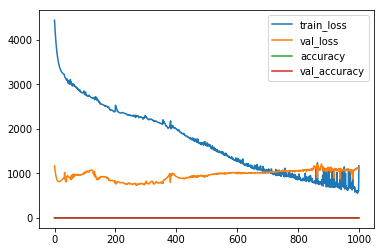

In [8]:
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# create and fit the LSTM network
sj_model = Sequential()

# stateful LSTM
# batch_size = 1
# sj_model.add(LSTM(16, batch_input_shape=(batch_size, sj_train_X.shape[1], sj_train_X.shape[2]), stateful=True))

sj_model.add(LSTM(units=4, input_shape=(sj_train_X.shape[1], sj_train_X.shape[2]), return_sequences=False))
# sj_model.add(LSTM(units=8, input_shape=(sj_train_X.shape[1], sj_train_X.shape[2]), return_sequences=False))
sj_model.add(Dense(output_dim=1))

sj_model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
hist = sj_model.fit(sj_train_X, sj_train_y, epochs=1000, batch_size=1, verbose=2,
          validation_data=(sj_test_X, sj_test_y), shuffle=False)


# losses = []
# val_losses = []
# for i in range(300):
#     hist = sj_model.fit(sj_train_X, sj_train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False,
#                 validation_data=(sj_test_X, sj_test_y))
#     losses.append(hist.history['loss'][0])
#     val_losses.append(hist.history['val_loss'][0])
#     sj_model.reset_states()

# plt.plot(losses, label='train_loss')
# plt.plot(val_losses, label='val_loss')
# plt.legend()
# plt.show()
    
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  if __name__ == '__main__':


Train on 390 samples, validate on 130 samples
Epoch 1/100
 - 1s - loss: 140.2165 - acc: 0.2179 - val_loss: 259.8010 - val_acc: 0.0846
Epoch 2/100
 - 0s - loss: 139.0818 - acc: 0.2179 - val_loss: 257.9491 - val_acc: 0.0846
Epoch 3/100
 - 0s - loss: 137.9595 - acc: 0.2179 - val_loss: 256.1121 - val_acc: 0.0846
Epoch 4/100
 - 0s - loss: 136.8490 - acc: 0.2179 - val_loss: 254.2905 - val_acc: 0.0923
Epoch 5/100
 - 0s - loss: 135.7496 - acc: 0.2282 - val_loss: 252.4824 - val_acc: 0.1231
Epoch 6/100
 - 0s - loss: 134.6604 - acc: 0.1564 - val_loss: 250.6850 - val_acc: 0.1154
Epoch 7/100
 - 0s - loss: 133.5809 - acc: 0.1128 - val_loss: 248.9327 - val_acc: 0.1154
Epoch 8/100
 - 0s - loss: 132.5326 - acc: 0.0821 - val_loss: 247.1479 - val_acc: 0.1154
Epoch 9/100
 - 0s - loss: 131.4697 - acc: 0.0821 - val_loss: 245.3659 - val_acc: 0.1154
Epoch 10/100
 - 0s - loss: 130.4141 - acc: 0.0821 - val_loss: 243.5844 - val_acc: 0.1154
Epoch 11/100
 - 0s - loss: 129.3649 - acc: 0.0821 - val_loss: 241.8014 - 

Epoch 94/100
 - 0s - loss: 95.5539 - acc: 0.0615 - val_loss: 165.6931 - val_acc: 0.0154
Epoch 95/100
 - 0s - loss: 95.5120 - acc: 0.0615 - val_loss: 165.7083 - val_acc: 0.0154
Epoch 96/100
 - 0s - loss: 95.4693 - acc: 0.0615 - val_loss: 165.7094 - val_acc: 0.0154
Epoch 97/100
 - 0s - loss: 95.4256 - acc: 0.0641 - val_loss: 165.6962 - val_acc: 0.0154
Epoch 98/100
 - 0s - loss: 95.3806 - acc: 0.0641 - val_loss: 165.6688 - val_acc: 0.0154
Epoch 99/100
 - 0s - loss: 95.3340 - acc: 0.0667 - val_loss: 165.6266 - val_acc: 0.0154
Epoch 100/100
 - 0s - loss: 95.2854 - acc: 0.0667 - val_loss: 165.5710 - val_acc: 0.0154


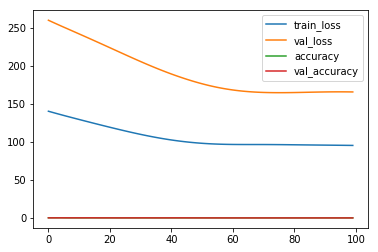

In [9]:
# create and fit the LSTM network
iq_model = Sequential()

# stateful LSTM
# batch_size = 1
# sj_model.add(LSTM(16, batch_input_shape=(batch_size, sj_train_X.shape[1], sj_train_X.shape[2]), stateful=True))

iq_model.add(LSTM(units=32, input_shape=(iq_train_X.shape[1], iq_train_X.shape[2]), return_sequences=False))
iq_model.add(Dense(output_dim=1))

iq_model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
hist = iq_model.fit(iq_train_X, iq_train_y, epochs=100, batch_size=len(iq_train_X), verbose=2,
          validation_data=(iq_test_X, iq_test_y), shuffle=False)


# losses = []
# val_losses = []
# for i in range(300):
#     hist = sj_model.fit(sj_train_X, sj_train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False,
#                 validation_data=(sj_test_X, sj_test_y))
#     losses.append(hist.history['loss'][0])
#     val_losses.append(hist.history['val_loss'][0])
#     sj_model.reset_states()

# plt.plot(losses, label='train_loss')
# plt.plot(val_losses, label='val_loss')
# plt.legend()
# plt.show()
    
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()


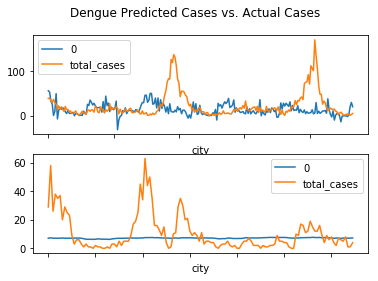

In [10]:
figs, axes = plt.subplots(nrows=2, ncols=1)

sj_pred_val = sj_model.predict(sj_test_X)
iq_pred_val = iq_model.predict(iq_test_X)

# plot sj
# sj_pred_val = []
# for x in sj_test_X:
#     x = np.reshape(x, (1, x.shape[0], x.shape[1]))
#     pred = sj_model.predict(x)
#     sj_pred_val.append(pred[0])

sj_pred_val = pd.DataFrame(sj_pred_val)
# .apply(lambda x : ((x * x)**0.5))
sj_pred_val.plot(ax=axes[0], label="Predictions")
sj_test_y.plot(ax=axes[0], label="Actual")

# plot iq
iq_pred_val = pd.DataFrame(iq_pred_val)
# .apply(lambda x : ((x * x)**0.5))
iq_pred_val.plot(ax=axes[1], label="Predictions")
iq_test_y.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()


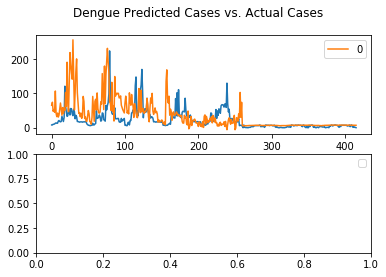

In [11]:
sj_pred = sj_model.predict(sj_test)
sj_pred = pd.DataFrame(sj_pred)
# sj_pred = sj_pred.apply(lambda x : ((x * x)**0.5) * SJ_DIVIDE_FACTOR).astype(int)

iq_pred = iq_model.predict(iq_test)
iq_pred = pd.DataFrame(iq_pred)
# iq_pred = iq_pred.apply(lambda x : ((x * x)**0.5) * IQ_DIVIDE_FACTOR).astype(int)
pred_arr = np.concatenate([sj_pred, iq_pred])
pred = pd.DataFrame(pred_arr)
# minn = sj_pred.min()
# maxx = sj_pred.max()
# dx = (maxx - minn)[0]
# dx
# sj_pred = sj_pred.apply(lambda x : 10 * x / dx).astype(int)
# sj_pred
benchmark = pd.read_csv('submission_23.9.csv')

figs, axes = plt.subplots(nrows=2, ncols=1)

benchmark.total_cases.plot(ax=axes[0], label="Predictions")
pred.plot(ax=axes[0], label="Actual")
    
plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

plt.show()

# # # print("Comparison : MAE : " + str(mean_absolute_error(benchmark.total_cases, sj_pred)))

submission = pd.read_csv('submission_format.csv', index_col=[0, 1, 2])

submission.total_cases = pred_arr

submission.to_csv("submission_lstm.csv")


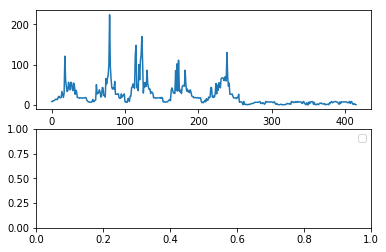

In [12]:
benchmark_23_9 = pd.read_csv('submission_23.9.csv')
benchmark_24_44 = pd.read_csv('submission_vibodha_24.44.csv')

figs, axes = plt.subplots(nrows=2, ncols=1)

benchmark_23_9.total_cases.plot(ax=axes[0], label="23.9")
# benchmark_24_44.total_cases.plot(ax=axes[0], label="24.44")
    
plt.legend()

plt.show()